In [32]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
BASE_PATH = "../results/all_limitless/baati"

def readAppData(path, skiprows=28):
    df = pd.read_csv(path, skiprows=skiprows, parse_dates=True)
    df["datetime"] = pd.to_datetime(df["time_h"])
    return df
    
def readResData(path):
    res = pd.read_csv(path)
    res["datetime"] = pd.to_datetime(res["time"], utc=True)
    return res
    
def readExp(expid, base_path=BASE_PATH, node="baati"):
    data_path = glob.glob(os.path.join(base_path, expid, f"VM_runtime_app_*.csv"))[0]
    res_path = glob.glob(os.path.join(base_path, expid, f"resources/metric_node_*_cpu.csv"))[0]
    return readAppData(data_path), readResData(res_path)


def dfInterval(df, tmin, tmax):
    return (tmin <= df["datetime"]) & (df["datetime"] <= tmax)

def getSplitTimestamps(df):
    ais = df["ai_name"].unique()
    ts = [df.loc[df["ai_name"] == ai, "datetime"].min() for ai in ais]
    ts.append(df["datetime"].max())
    ts.sort()
    return ts

def splitDF(df, timestampDF=None, ai_name="ai_1"):
    if timestampDF is None:
        timestampDF = df
    tss = getSplitTimestamps(timestampDF)
    if ai_name is not None:
        df = df[df["ai_name"] == ai_name]
    return [df[dfInterval(df, *ts)] for ts in zip(tss[:-1], tss[1:])]


def getMetrics(dfs, metric_name="app_latency"):
    metric = np.array([df2[metric_name].mean() for df2 in dfs])
    stddev = np.array([df2[metric_name].std() for df2 in dfs])
    return metric, stddev

def plotPerf(df, expid, metric_name="app_latency"):
    dfs = splitDF(df)
    fig, ax = plt.subplots()
    metric, metric_stddev = getMetrics(dfs)
    ax.errorbar(range(1, len(metric)+1), metric, yerr=metric_stddev)
    ax.set_ylabel(metric_name)
    ax.set_title(expid)
    plt.show()
    
def plotRegressionLine(ax, x, y, yerr, b, expid=None, metric_name="app_latency"): 
    x = np.array(x)
    ax.errorbar(x, y,yerr, color = "m", fmt="o") 
    #plt.scatter(x, y, color = "m", yerr=yerr, 
    #           marker = "o", s = 30) 
    y_pred = b[0] + b[1]*x 
    ax.plot(x, y_pred, color = "g") 
    #plt.show()
    
def getXs(ys):
    return list(range(1, len(ys)+1))

def fitRegression(ys):
    xs2 = [[i] for i in getXs(ys)]
    reg = linear_model.LinearRegression()
    reg.fit(xs2, ys)
    return np.array([reg.intercept_, reg.coef_[0]])

# expid, t1, t2, ai_name, tasks, avg_latency, avg_throughput, std_latency, std_throughput, latency_samples_count
def analizeData(expid, ax, base_path=BASE_PATH, metric_name="app_latency", rescale=False, silent=False):
    print(expid)
    df, res = readExp(expid, base_path=base_path)
    dfs = splitDF(df)
    ys, yerr = getMetrics(dfs, metric_name)
    if rescale:
        factor = ys[0]
        ys /= factor
        yerr /= factor
    coef = fitRegression(ys)
    if not silent:
        plotRegressionLine(ax, getXs(ys), ys, yerr, coef, expid, metric_name)
        #print (f"Coef: {coef}")
        #df[metric_name].plot()
        #plt.show()
        #res["value"].plot()
    return coef


def getCpuSinglePod(expid, role, ts, base_path=BASE_PATH, ai="ai-1"):
    tmin, tmax = ts
    path = glob.glob(os.path.join(base_path, expid, f"resources/metric_pod_*{role}-{ai}*_cpu.csv"))[0]
    res = readResData(path)
    return res.loc[(tmin < res["datetime"]) & (res["datetime"] < tmax), ["datetime", "value"]]

def getCpuLimits(ai_type_role, factor=2.):
    def getExpid(ai_type):
        if ai_type == "redis_ycsb":
            ai_type = "redis"
        return f"{ai_type}_1"
    result = []
    for ai_type, roles in ai_type_role.items():
        expid = getExpid(ai_type)
        print(expid)
        df, _ = readExp(expid)
        tmax = df.loc[df["ai_name"] == "ai_2", "datetime"].min()
        tmin = df.loc[df["ai_name"] == "ai_1", "datetime"].min()
        ts = (tmin, tmax)
        for role in roles:
            res = getCpuSinglePod(expid, role, ts)
            limit = int(res["value"].mean() * factor)
            result.append((ai_type, role, limit))
    return result



In [33]:
def getExpid(t1, t2):
    return f"{t1}_{t2}_1" if t1 != t2 else f"{t1}_1"

def shortTypeToLong(t1):
    return "redis_ycsb" if t1 == "redis" else t1

#TODO fix naming of experiments
ai_type_role = dict()
ai_type_role["redis"] = ["ycsb", "redis"]
ai_type_role["hadoop"] = ["hadoopmaster", "hadoopslave"]
ai_type_role["linpack"] = ["linpack"]
ai_type_role["wrk"] = ["wrk", "apache"]

t1 = "redis"
t2s = ["redis", "wrk", "hadoop", "linpack"]
n = len(t2s)

# DF: expid, t1, t2, ai_name, ai_role, tasks, avg_cpu, std_cpu, cpu_samples_count
def getResourceDatapoint(t1, t2, ai_no, ai_role, tasks, ts, res):
    res = res.loc[dfInterval(res, *ts), ["datetime", "value"]]
    res = res["value"]
    d = {"expid": getExpid(t1, t2), "t1": t1, "t2": t2, "ai_name": f"ai-{ai_no+1}"}
    d.update({"ai_role": ai_role, "tasks": tasks})
    d.update({"avg_cpu": res.mean(), "std_cpu": res.std(), "cpu_samples_count": res.count()})
    
    d2 = {}
    for k, v in d.items():
        d2.update({k: pd.Series(v, index=[0])})
    return pd.DataFrame(d2)

def getResourceDatapointsRole(t1, t2, ai_no, ai_role, tss):
    expid = getExpid(t1, t2)
    exp_dir = os.path.join(BASE_PATH, expid)
    results = pd.DataFrame()
    try:
        path = glob.glob(os.path.join(exp_dir, f"resources/metric_pod_*{ai_role}-ai-{ai_no+1}*_cpu.csv"))[0]
    except IndexError as err:
        raise ValueError(f"No resource record in directory {exp_dir} for ai_role \
            {ai_role} and ai no. {ai_no+1}") from None
    res = readResData(path)
    for tasks in range(ai_no, len(tss)):
        result = getResourceDatapoint(t1, t2, ai_no, ai_role, tasks, tss[tasks], res)
        results = results.append(result, ignore_index=True)
    return results
            

def getResourceDatapoints(t1, t2, ai_nr, tss):
    results = pd.DataFrame()
    t = t1 if not ai_nr else t2
    for ai_role in ai_type_role[t]:
        result = getResourceDatapointsRole(t1, t2, ai_nr, ai_role, tss)
        results = results.append(result, ignore_index=True)
    return results


# select expid, tasks, sum cpu
# expid -> {tasks{1,..,6}: sum_cpu}
# join with expid, tasks, performance

resources = pd.DataFrame()
results = pd.DataFrame()
for t2 in t2s:
    expid = getExpid(t1, t2)
    df, _ = readExp(expid)
    ts = getSplitTimestamps(df)
    tss = list(zip(ts[:-1], ts[1:]))
    max_ais = len(tss)
    for ai_no in range(max_ais):
        result = getResourceDatapoints(t1, t2, ai_no, tss)
        results = results.append(result, ignore_index=True)
print(results)
results.info()
res = results
    

               expid     t1       t2 ai_name  ai_role  tasks      avg_cpu  \
0            redis_1  redis    redis    ai-1     ycsb      0  1185.285714   
1            redis_1  redis    redis    ai-1     ycsb      1  1171.500000   
2            redis_1  redis    redis    ai-1     ycsb      2  1127.952381   
3            redis_1  redis    redis    ai-1     ycsb      3  1071.095238   
4            redis_1  redis    redis    ai-1     ycsb      4   997.190476   
..               ...    ...      ...     ...      ...    ...          ...   
126  redis_linpack_1  redis  linpack    ai-4  linpack      4  1585.100000   
127  redis_linpack_1  redis  linpack    ai-4  linpack      5  1466.900000   
128  redis_linpack_1  redis  linpack    ai-5  linpack      4  1530.400000   
129  redis_linpack_1  redis  linpack    ai-5  linpack      5  1464.000000   
130  redis_linpack_1  redis  linpack    ai-6  linpack      5  1546.888889   

        std_cpu  cpu_samples_count  
0     23.413976                 21  
1

In [42]:
res.info()
cpu_sum = res.groupby(["expid", "tasks"]).sum()
cpu_sum

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   expid              131 non-null    object 
 1   t1                 131 non-null    object 
 2   t2                 131 non-null    object 
 3   ai_name            131 non-null    object 
 4   ai_role            131 non-null    object 
 5   tasks              131 non-null    int64  
 6   avg_cpu            131 non-null    float64
 7   std_cpu            131 non-null    float64
 8   cpu_samples_count  131 non-null    int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 9.3+ KB


avg_cpu      std_cpu  cpu_samples_count
expid           tasks                                             
redis_1         0      1418.085714    38.671761                 41
                1      2806.690476    84.501883                 83
                2      4076.047619   152.788138                126
                3      5136.190476   225.058627                168
                4      6051.476190   325.228432                210
                5      6798.850000   357.324447                240
redis_hadoop_1  0      1417.739130    67.850648                 46
                1      2887.826840  1043.674178                 85
                2      4594.203463  2320.252984                131
                3      5938.865497  3578.793539                151
redis_linpack_1 0      1415.818182    29.115664                 22
                1      3162.881818    77.627175                 31
                2      4669.509091   225.052869                 43
                3      6046.545455   351.322842                 55
                4      7298.172727   442.481548                 61
                5      8320.700000   803.810193                 68
redis_wrk_1     0      1420.428571    39.208081                 42
                1      3486.650000   160.972286                 80
                2      5144.000000   276.298123                126
                3      6150.428571   294.424676                168
                4      6779.857143   651.108388                210
                5      7091.050000   725.776289                240

In [39]:
def getMetricsTmp(expid, metric_name="app_latency"):
    df = readExp(expid)
    dfs = splitDF(df)
    ys, yerr = getMetrics(dfs, metric_name)
    
# parse all csvs
# expid -> 

pandas.core.series.Series

In [9]:
expid = "redis_1"
print(getCpuLimits(ai_type_role))

redis_1
hadoop_1
linpack_1
wrk_1
[('redis_ycsb', 'ycsb', 2370), ('redis_ycsb', 'redis', 465), ('hadoop', 'hadoopmaster', 1313), ('hadoop', 'hadoopslave', 2238), ('linpack', 'linpack', 3593), ('wrk', 'wrk', 1784), ('wrk', 'apache', 2834)]


redis_1
redis_wrk_1
redis_hadoop_1
redis_linpack_1
wrk_redis_1
wrk_1
wrk_hadoop_1
wrk_linpack_1
hadoop_redis_1
hadoop_wrk_1
hadoop_1
hadoop_linpack_1
linpack_redis_1
linpack_wrk_1
linpack_hadoop_1
linpack_1


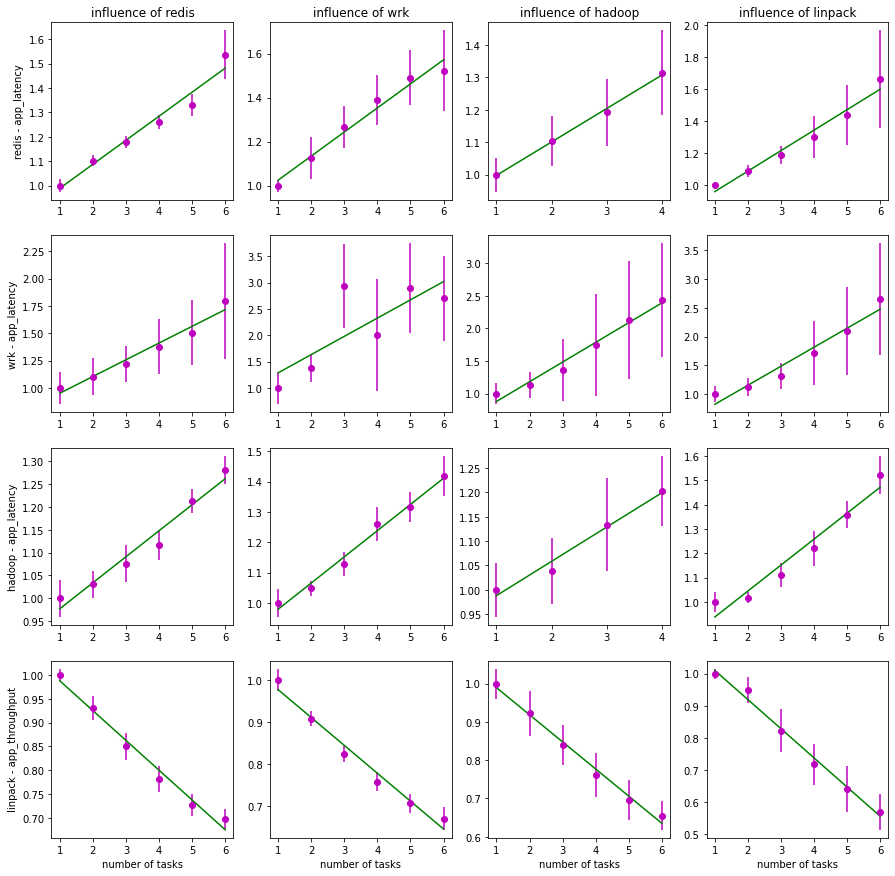

[[0.09850463 0.10939086 0.10299651 0.12770357]
 [0.15296261 0.34636941 0.30279389 0.33084764]
 [0.05699619 0.08645344 0.07038867 0.10692214]
 [0.06254286 0.06645851 0.0709298  0.09099933]]


In [8]:
"""
# TODO print cost function
"""
def formatLegend(ax, expid, metric_name, i, j, n):
    expid_parts = expid.split("_")
    xtask = expid_parts[0]
    if len(expid_parts) <= 2:
        ytask = expid_parts[0]
    else:
        ytask = expid_parts[1]
    
    if j == n-1:
        ax.set_xlabel('number of tasks') 
    if not j:
        ax.set_title(f"influence of {ytask}")
    if not i:
        ax.set_ylabel(f"{xtask} - {metric_name}") 

tasks = ["redis", "wrk", "hadoop", "linpack"]
#tasks = ["redis", "wrk"]
n = len(tasks)
expids = [getExpid(t1, t2) for t1 in tasks for t2 in tasks]
#print(expids)
rescale=True
silent=False

inference = []
fig, axes = plt.subplots(n, n, figsize=(15., 15.))
for i, expid in enumerate(expids):
    if expid.startswith("linpack"):
        metric = "app_throughput"
        sign = -1.
    else:
        metric ="app_latency"
        sign = 1.
    j, k = int(i / n), int(i % n)
    ax = axes[j, k]
    formatLegend(ax, expid, metric, k, j, n)
    coefs = analizeData(expid, ax, metric_name=metric, rescale=rescale, silent=silent)
    inference.append(coefs[1] * sign)
plt.show()
inference = np.array(inference)
inference.resize([n, n])
print(inference)

12.0


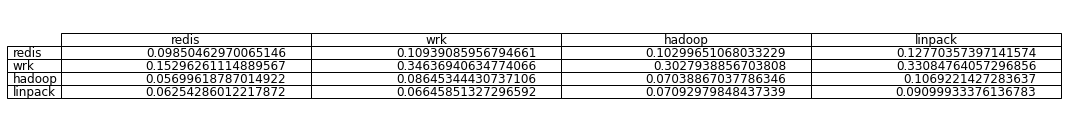

In [24]:
fig, ax = plt.subplots()
fig.patch.set_visible(False)
fig.set_size_inches((15, 2))
ax.axis("off")
ax.axis("tight")

def_size = plt.rcParams["font.size"]
plt.rcParams.update({"font.size": 12.})
print(def_size)


df = pd.DataFrame(inference, columns=tasks)
ax.table(cellText=df.values, colLabels=df.columns,rowLabels=tasks, loc="center")
fig.tight_layout()
plt.show()

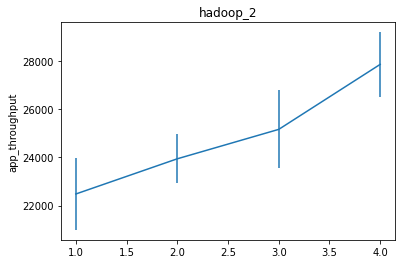

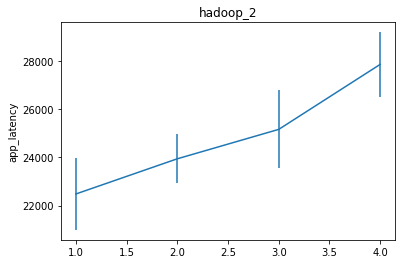

In [3]:
expid = "hadoop_2"
#TODO resilient to expid vs dir
Coef: [33.26514094 -2.22451136]

hadoop_1

Coef: [20864.85238095  1600.41714286]

hadoop_linpack_1

Coef: [18129.22555556  2332.67761905]

'\ndf = readDF(expid) \ndfs = splitDF(df)\nys, _ = getMetrics(dfs)\nxs = list(range(1, len(ys)+1))\nxs2 = [[i] for i in xs]\nreg = linear_model.LinearRegression()\nreg.fit(xs2, ys)\ncoef = np.array([reg.intercept_, reg.coef_[0]])\nprint(f"Reg coeff: {coef}")\n\n# Plot metric\n# Plot \n\nplot_regression_line(xs, ys, coef)\n# TODO wrap into function\n# TODO print cost function\n'


df = readDF(expid, "../results/all_limitless/baati") 
plotPerf(df, expid, "app_throughput")
plotPerf(df, expid, "app_latency")

In [53]:
dir(reg)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_preprocess_data',
 '_residues',
 '_set_intercept',
 'coef_',
 'copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'n_jobs',
 'normalize',
 'predict',
 'rank_',
 'score',
 'set_params',
 'singular_']

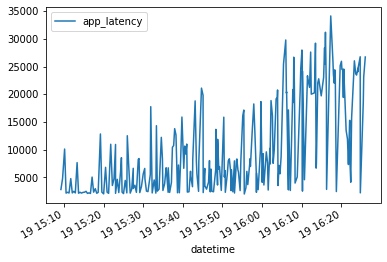

In [27]:
df.plot(x="datetime", y="app_latency")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ef35a2710>],
      dtype=object)

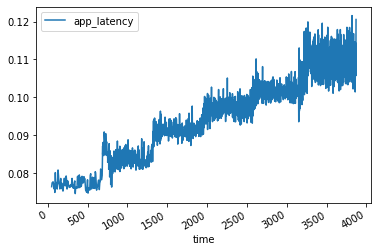

In [45]:
lat = df["app_latency"]
#lat.min()
#df.info()
df2 = df
for ai in df["ai_name"].unique():
    df2[f"latency_{ai}"] = df.loc[df["ai_name"] == ai, "app_latency"]
#df2.info()
df2.plot(x="time", y="app_latency", subplots=True)

In [46]:
cols = [f"latency_{ai}" for ai in df["ai_name"].unique()]
df3 = df2[["datetime"] + cols]

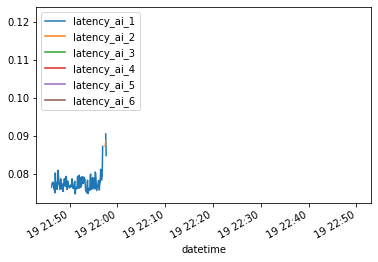

In [48]:
df3.plot(x="datetime")